# **Without Overload Condition**

Upload a FAULTY thermal image (jpg/png):


Saving T12_faulty_001.jpg to T12_faulty_001 (2).jpg


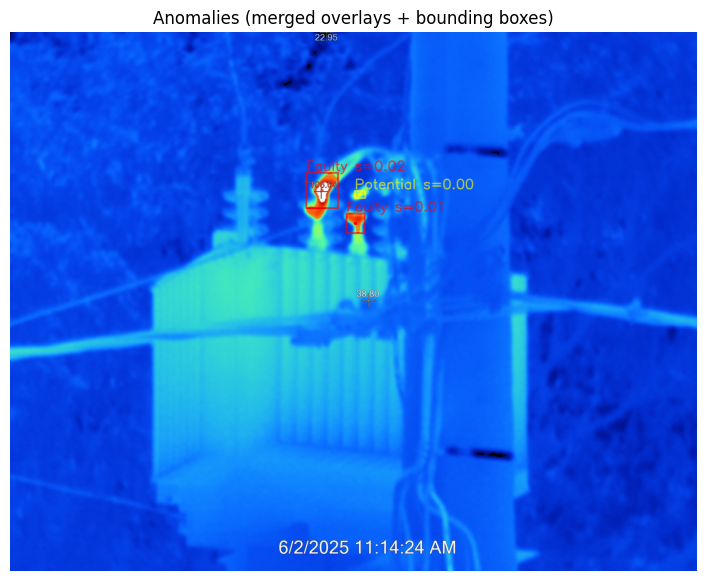

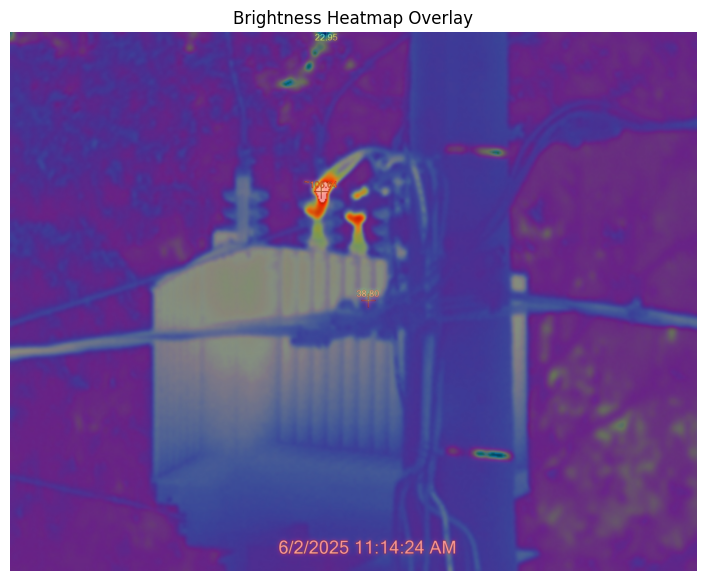

Merged anomaly metadata:
[1] bbox=(1198, 646, 65, 70)  centroid=(1230, 681)  area_px=2415  severity=0.0058  label=Faulty
[2] bbox=(1228, 566, 37, 25)  centroid=(1246, 578)  area_px=426  severity=0.0012  label=Potential
[3] bbox=(1055, 501, 113, 126)  centroid=(1111, 564)  area_px=5798  severity=0.0237  label=Faulty
Saved: T12_faulty_001 (2)_annotated.png
Saved: T12_faulty_001 (2)_heatmap.png


In [40]:
# === Phase 2 · Automatic Anomaly Marking with MERGE (built on your method) ===
from google.colab import files
import cv2, numpy as np, matplotlib.pyplot as plt, os

print("Upload a FAULTY thermal image (jpg/png):")
up = files.upload()
assert len(up) > 0, "No file uploaded."
image_path = list(up.keys())[0]

def detect_anomalies(image_path,
                     min_area: int = 60,
                     ignore_right_ratio: float = 0.10,   # 10% right strip (temp bar)
                     overlay_alpha: float = 0.35,
                     iou_thr: float = 0.15,              # merge if IoU >= this
                     gap_px_factor: float = 0.004        # merge if edge gap <= factor*max(H,W)
                     ):
    """
    Returns:
      annotated_img  -> original + filled overlays + bounding boxes + labels
      heatmap_blend  -> original + brightness heatmap (visual aid)
      anomalies      -> list[ dict(bbox, centroid, area_px, severity, label) ]  AFTER MERGING
    """
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(image_path)
    H, W = img.shape[:2]
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    v   = hsv[:, :, 2]

    # --- Your HSV masks (slightly stricter S/V to reduce rails) ---
    mask_red    = cv2.inRange(hsv, (0,  60, 180), (20, 255, 255))   # Faulty (red/orange)
    mask_yellow = cv2.inRange(hsv, (20, 60, 180), (40, 255, 255))   # Potential (yellow)
    mask = cv2.bitwise_or(mask_red, mask_yellow)

    # Ignore right-side temperature scale if present
    if ignore_right_ratio > 0:
        cut = int(W * (1.0 - ignore_right_ratio))
        for m in (mask, mask_red, mask_yellow):
            m[:, cut:] = 0

    # --- Clean AND slightly expand to cover the whole hotspot ---
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8), iterations=1)
    mask = cv2.dilate(mask, np.ones((3,3), np.uint8), iterations=1)  # expand by 1px radius

    # --- Contours -> raw anomaly items ---
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    items = []  # keep mask per contour so we can recompute severity after merging

    def severity_from_bbox(x, y, w, h, region_mask):
        roi_v   = v[y:y+h, x:x+w]
        roi_hot = region_mask[y:y+h, x:x+w]
        if cv2.countNonZero(roi_hot) == 0:
            return 0.0
        hot_mean = cv2.mean(roi_v, mask=roi_hot)[0]
        rim = cv2.dilate(roi_hot, np.ones((11,11), np.uint8), iterations=1)
        bg_mask = cv2.subtract(rim, roi_hot)
        bg_mask = np.where(bg_mask > 0, 255, 0).astype(np.uint8)
        bg_mean = cv2.mean(roi_v, mask=bg_mask)[0] if cv2.countNonZero(bg_mask) else float(np.mean(roi_v))
        contrast = max(0.0, (hot_mean - bg_mean) / 255.0)   # 0..1
        area_norm = min(1.0, (w*h) / (H*W*0.05))            # cap at 5% of image
        return float(min(1.0, 0.7*contrast + 0.3*area_norm))

    for cnt in contours:
        area = int(cv2.contourArea(cnt))
        if area < min_area:
            continue
        x, y, w, h = cv2.boundingRect(cnt)

        # Decide label/color by red vs yellow pixels inside this bbox
        red_px = cv2.countNonZero(mask_red[y:y+h, x:x+w])
        yel_px = cv2.countNonZero(mask_yellow[y:y+h, x:x+w])
        if red_px > yel_px:
            label = "Faulty"; color = (0, 0, 255)
        else:
            label = "Potential"; color = (0, 255, 255)

        region_mask = np.zeros((H, W), np.uint8)
        cv2.drawContours(region_mask, [cnt], -1, 255, -1)

        items.append({
            "bbox": (x, y, w, h),
            "area_px": area,
            "label": label,
            "color": color,
            "mask": region_mask
        })

    # ---------------- Merge nearby/overlapping boxes ----------------
    def to_xyxy(b):
        x,y,w,h = b; return (x, y, x+w, y+h)

    def iou(a, b):
        ax1, ay1, ax2, ay2 = to_xyxy(a); bx1, by1, bx2, by2 = to_xyxy(b)
        ix1, iy1 = max(ax1,bx1), max(ay1,by1)
        ix2, iy2 = min(ax2,bx2), min(ay2,by2)
        iw, ih = max(0, ix2-ix1), max(0, iy2-iy1)
        inter = iw*ih
        area_a = (ax2-ax1)*(ay2-ay1); area_b = (bx2-bx1)*(by2-by1)
        union = area_a + area_b - inter + 1e-6
        return inter/union

    def gap_px(a, b):
        # shortest edge-to-edge distance (Chebyshev) between boxes
        ax1, ay1, ax2, ay2 = to_xyxy(a); bx1, by1, bx2, by2 = to_xyxy(b)
        dx = max(0, max(bx1-ax2, ax1-bx2))
        dy = max(0, max(by1-ay2, ay1-by2))
        return max(dx, dy)

    GAP = max(8, int(max(H,W)*gap_px_factor))
    merged = []
    used = [False]*len(items)

    for i in range(len(items)):
        if used[i]: continue
        used[i] = True
        x,y,w,h = items[i]["bbox"]
        union_mask = items[i]["mask"].copy()
        any_faulty = (items[i]["label"] == "Faulty")

        changed = True
        while changed:
            changed = False
            for j in range(len(items)):
                if used[j]: continue
                b1, b2 = (x,y,w,h), items[j]["bbox"]
                if iou(b1, b2) >= iou_thr or gap_px(b1, b2) <= GAP:
                    # merge j into current
                    used[j] = True
                    x2,y2,w2,h2 = b2
                    x = min(x, x2); y = min(y, y2)
                    w = max(x+w, x2+w2) - x
                    h = max(y+h, y2+h2) - y
                    union_mask = cv2.bitwise_or(union_mask, items[j]["mask"])
                    any_faulty = any_faulty or (items[j]["label"] == "Faulty")
                    changed = True

        # recompute severity on union mask + union box
        severity = severity_from_bbox(x, y, w, h, union_mask)
        label = "Faulty" if any_faulty else "Potential"
        color = (0,0,255) if label=="Faulty" else (0,255,255)

        merged.append({
            "bbox": (x,y,w,h),
            "centroid": (x + w//2, y + h//2),
            "area_px": int(cv2.countNonZero(union_mask)),
            "severity": round(severity, 4),
            "label": label,
            "color": color,
            "mask": union_mask
        })

    # ---------------- Draw overlays + boxes for MERGED anomalies ----------------
    overlay   = img.copy()
    annotated = img.copy()
    th = max(2, int(min(H, W) * 0.003))
    font_scale = max(0.5, min(H, W) / 1200.0)

    for a in merged:
        # filled overlay
        cnts,_ = cv2.findContours(a["mask"], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay, cnts, -1, a["color"], thickness=-1)

        x,y,w,h = a["bbox"]; cx,cy = a["centroid"]
        cv2.rectangle(annotated, (x,y), (x+w, y+h), a["color"], th)
        cv2.circle(annotated, (cx,cy), max(2, th+1), a["color"], -1)
        cv2.putText(annotated, f"{a['label']} s={a['severity']:.2f}",
                    (x, max(20, y-8)), cv2.FONT_HERSHEY_SIMPLEX, font_scale, a["color"], max(2, th-1))

    annotated = cv2.addWeighted(overlay, overlay_alpha, annotated, 1 - overlay_alpha, 0)

    # --- Heatmap (unchanged) ---
    v_norm = cv2.normalize(v, None, 0, 255, cv2.NORM_MINMAX)
    v_blur = cv2.GaussianBlur(v_norm, (0,0), sigmaX=7, sigmaY=7)
    heat   = cv2.applyColorMap(v_blur.astype(np.uint8), cv2.COLORMAP_JET)
    heatmap_blend = cv2.addWeighted(img, 0.6, heat, 0.4, 0)

    # Strip masks from metadata for printing
    out_meta = [{k:v for k,v in a.items() if k != "mask"} for a in merged]
    return annotated, heatmap_blend, out_meta


# === Run detection on uploaded image ===
annotated_img, heatmap_img, meta = detect_anomalies(image_path)

# Show overlays + boxes (MERGED)
plt.figure(figsize=(12, 7))
plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Anomalies (merged overlays + bounding boxes)")
plt.show()

# Heatmap view (optional)
plt.figure(figsize=(12, 7))
plt.imshow(cv2.cvtColor(heatmap_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Brightness Heatmap Overlay")
plt.show()

# Metadata printout
if len(meta) == 0:
    print("No anomalies found with current thresholds.")
else:
    print("Merged anomaly metadata:")
    for i, m in enumerate(meta, 1):
        print(f"[{i}] bbox={m['bbox']}  centroid={m['centroid']}  "
              f"area_px={m['area_px']}  severity={m['severity']}  label={m['label']}")

# Save images
stem, _ = os.path.splitext(image_path)
cv2.imwrite(f"{stem}_annotated.png", annotated_img)
cv2.imwrite(f"{stem}_heatmap.png", heatmap_img)
print("Saved:", f"{stem}_annotated.png")
print("Saved:", f"{stem}_heatmap.png")


# **With Overload Condition**




Upload a FAULTY thermal image (jpg/png):


Saving T7_faulty_003.jpg to T7_faulty_003 (1).jpg


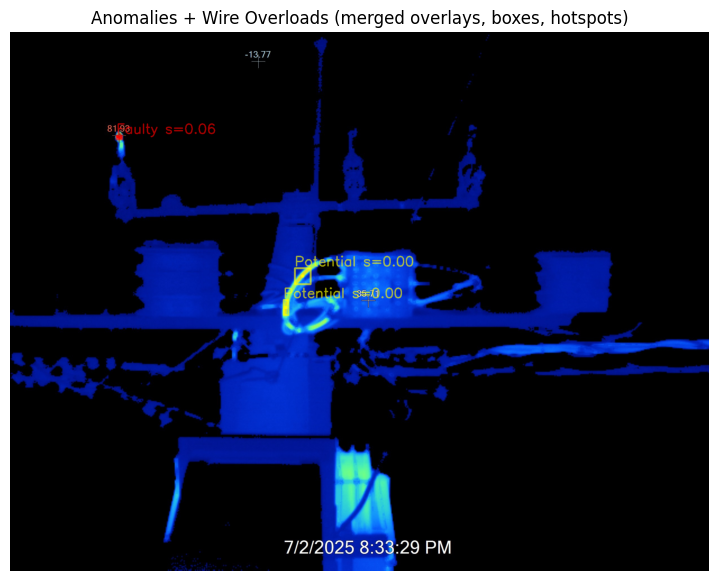

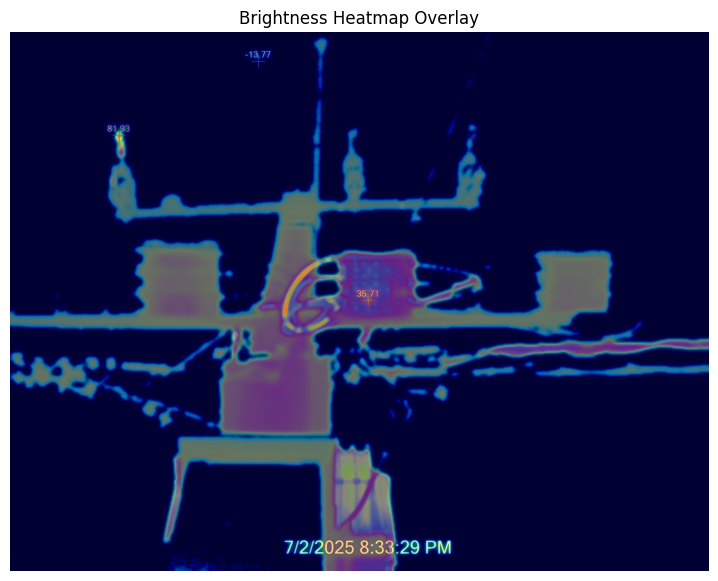

Anomaly metadata (merged + wires):
[1] bbox=(974, 954, 17, 54)  centroid=(982, 981)  area_px=573  severity=0.0012  label=Potential s=0.00
[2] bbox=(1014, 841, 56, 57)  centroid=(1042, 869)  area_px=856  severity=0.004  label=Potential s=0.00
[3] bbox=(379, 369, 19, 13)  centroid=(388, 375)  area_px=154  severity=0.062  label=Faulty s=0.06
Saved: T7_faulty_003 (1)_annotated.png
Saved: T7_faulty_003 (1)_heatmap.png


In [48]:
# === Phase 2 · Automatic Anomaly Marking + WIRE OVERLOADS (built on your method) ===
from google.colab import files
import cv2, numpy as np, matplotlib.pyplot as plt, os, math

print("Upload a FAULTY thermal image (jpg/png):")
up = files.upload()
assert len(up) > 0, "No file uploaded."
image_path = list(up.keys())[0]

def detect_anomalies(image_path,
                     min_area: int = 60,
                     ignore_right_ratio: float = 0.10,   # 10% right strip (temp bar)
                     overlay_alpha: float = 0.35,
                     iou_thr: float = 0.15,              # merge if IoU >= this
                     gap_px_factor: float = 0.004,       # merge if edge gap <= factor*max(H,W)
                     # --- wire heuristics ---
                     wire_ar_min: float = 6.0,           # min aspect ratio (length/thickness) for wire
                     wire_len_frac: float = 0.15,        # min length as fraction of diagonal
                     full_wire_fill: float = 0.35        # fill ratio inside bbox -> full wire overload
                     ):
    """
    Returns:
      annotated_img  -> original + filled overlays + bounding boxes + labels (+ wire hotspots)
      heatmap_blend  -> original + brightness heatmap (visual aid)
      anomalies      -> list[ dict(...) ] AFTER MERGING, with wire overload classifications when applicable
    """
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(image_path)
    H, W = img.shape[:2]
    D = math.hypot(H, W)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    v   = hsv[:, :, 2]

    # --- HSV masks (kept; slightly stricter S/V) ---
    mask_red    = cv2.inRange(hsv, (0,  60, 180), (20, 255, 255))   # Faulty (red/orange)
    mask_yellow = cv2.inRange(hsv, (20, 60, 180), (40, 255, 255))   # Potential (yellow)
    mask = cv2.bitwise_or(mask_red, mask_yellow)

    # Ignore right-side temperature scale if present
    if ignore_right_ratio > 0:
        cut = int(W * (1.0 - ignore_right_ratio))
        for m in (mask, mask_red, mask_yellow):
            m[:, cut:] = 0

    # --- Clean & slightly expand to cover the whole hotspot ---
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8), iterations=1)
    mask = cv2.dilate(mask, np.ones((3,3), np.uint8), iterations=1)

    # --- Contours -> raw anomaly items ---
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    items = []  # keep mask per contour so we can recompute severity/overload after merging

    def severity_from_bbox(x, y, w, h, region_mask):
        roi_v   = v[y:y+h, x:x+w]
        roi_hot = region_mask[y:y+h, x:x+w]
        if cv2.countNonZero(roi_hot) == 0:
            return 0.0
        hot_mean = cv2.mean(roi_v, mask=roi_hot)[0]
        rim = cv2.dilate(roi_hot, np.ones((11,11), np.uint8), iterations=1)
        bg_mask = cv2.subtract(rim, roi_hot)
        bg_mask = np.where(bg_mask > 0, 255, 0).astype(np.uint8)
        bg_mean = cv2.mean(roi_v, mask=bg_mask)[0] if cv2.countNonZero(bg_mask) else float(np.mean(roi_v))
        contrast = max(0.0, (hot_mean - bg_mean) / 255.0)   # 0..1
        area_norm = min(1.0, (w*h) / (H*W*0.05))            # cap at 5% of image
        return float(min(1.0, 0.7*contrast + 0.3*area_norm))

    for cnt in contours:
        area = int(cv2.contourArea(cnt))
        if area < min_area:
            continue
        x, y, w, h = cv2.boundingRect(cnt)

        # label/color from red vs yellow content
        red_px = cv2.countNonZero(mask_red[y:y+h, x:x+w])
        yel_px = cv2.countNonZero(mask_yellow[y:y+h, x:x+w])
        if red_px > yel_px:
            label = "Faulty"; color = (0, 0, 255)
        else:
            label = "Potential"; color = (0, 255, 255)

        region_mask = np.zeros((H, W), np.uint8)
        cv2.drawContours(region_mask, [cnt], -1, 255, -1)

        items.append({
            "bbox": (x, y, w, h),
            "area_px": area,
            "label": label,
            "color": color,
            "mask": region_mask
        })

    # ---------------- Merge nearby/overlapping boxes ----------------
    def to_xyxy(b):
        x,y,w,h = b; return (x, y, x+w, y+h)
    def iou(a, b):
        ax1, ay1, ax2, ay2 = to_xyxy(a); bx1, by1, bx2, by2 = to_xyxy(b)
        ix1, iy1 = max(ax1,bx1), max(ay1,by1)
        ix2, iy2 = min(ax2,bx2), min(ay2,by2)
        iw, ih = max(0, ix2-ix1), max(0, iy2-iy1)
        inter = iw*ih
        area_a = (ax2-ax1)*(ay2-ay1); area_b = (bx2-bx1)*(by2-by1)
        union = area_a + area_b - inter + 1e-6
        return inter/union
    def gap_px(a, b):
        ax1, ay1, ax2, ay2 = to_xyxy(a); bx1, by1, bx2, by2 = to_xyxy(b)
        dx = max(0, max(bx1-ax2, ax1-bx2))
        dy = max(0, max(by1-ay2, ay1-by2))
        return max(dx, dy)

    GAP = max(8, int(max(H,W)*gap_px_factor))
    merged = []
    used = [False]*len(items)

    for i in range(len(items)):
        if used[i]: continue
        used[i] = True
        x,y,w,h = items[i]["bbox"]
        union_mask = items[i]["mask"].copy()
        any_faulty = (items[i]["label"] == "Faulty")

        changed = True
        while changed:
            changed = False
            for j in range(len(items)):
                if used[j]: continue
                b1, b2 = (x,y,w,h), items[j]["bbox"]
                if iou(b1, b2) >= iou_thr or gap_px(b1, b2) <= GAP:
                    used[j] = True
                    x2,y2,w2,h2 = b2
                    x = min(x, x2); y = min(y, y2)
                    w = max(x+w, x2+w2) - x
                    h = max(y+h, y2+h2) - y
                    union_mask = cv2.bitwise_or(union_mask, items[j]["mask"])
                    any_faulty = any_faulty or (items[j]["label"] == "Faulty")
                    changed = True

        severity = severity_from_bbox(x, y, w, h, union_mask)
        label = "Faulty" if any_faulty else "Potential"
        color = (0,0,255) if label=="Faulty" else (0,255,255)

        merged.append({
            "bbox": (x,y,w,h),
            "centroid": (x + w//2, y + h//2),
            "area_px": int(cv2.countNonZero(union_mask)),
            "severity": round(severity, 4),
            "label": label,
            "color": color,
            "mask": union_mask
        })

    # ---------------- Wire overload analysis (on merged masks) ----------------
    def classify_wire(a):
        """Return (overload_type, hotspot_xy) or (None, None) if not a wire."""
        x,y,w,h = a["bbox"]
        comp_mask = a["mask"].copy()
        # minAreaRect to estimate length/thickness robustly (handles curved-ish shapes)
        ys, xs = np.where(comp_mask > 0)
        if xs.size == 0: return None, None
        pts = np.column_stack((xs, ys)).astype(np.float32)
        rect = cv2.minAreaRect(pts)  # ((cx,cy),(w,h),angle)
        rw, rh = rect[1]
        if rw == 0 or rh == 0: return None, None
        length = max(rw, rh)
        thickness = min(rw, rh)
        ar = (length + 1e-6) / (thickness + 1e-6)

        # is it a wire-like hot component?
        if ar < wire_ar_min or length < wire_len_frac * D:
            return None, None

        # fill ratio in bbox (how much of bbox is hot)
        fill = a["area_px"] / float(max(1, w*h))

        # pick the absolute hottest pixel inside this wire
        v_wire = v * (comp_mask.astype(np.uint8) // 255)
        minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(v_wire)
        hx, hy = int(maxLoc[0]), int(maxLoc[1])

        # Determine color content inside wire (red vs yellow)
        red_in = cv2.countNonZero(mask_red[y:y+h, x:x+w])
        yel_in = cv2.countNonZero(mask_yellow[y:y+h, x:x+w])

        # Classify
        if fill >= full_wire_fill:
            overload_type = "Full Wire Overload (Potential)"
        else:
            if red_in > yel_in:
                overload_type = "Point Overload (Faulty)"
            else:
                overload_type = "Point Overload (Potential)"

        return overload_type, (hx, hy)

    # ---------------- Draw overlays + boxes + wire hotspots ----------------
    overlay   = img.copy()
    annotated = img.copy()
    th = max(2, int(min(H, W) * 0.003))
    font_scale = max(0.5, min(H, W) / 1200.0)

    out_meta = []
    for a in merged:
        # wire classification
        overload_type, hotspot = classify_wire(a)

        # draw filled overlay
        cnts,_ = cv2.findContours(a["mask"], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay, cnts, -1, a["color"], thickness=-1)

        # bbox + centroid
        x,y,w,h = a["bbox"]; cx,cy = a["centroid"]
        cv2.rectangle(annotated, (x,y), (x+w, y+h), a["color"], th)
        cv2.circle(annotated, (cx,cy), max(2, th+1), a["color"], -1)

        # choose display label
        disp_label = overload_type if overload_type else f"{a['label']} s={a['severity']:.2f}"
        cv2.putText(annotated, disp_label,
                    (x, max(20, y-8)), cv2.FONT_HERSHEY_SIMPLEX, font_scale, a["color"], max(2, th-1))

        # hotspot crosshair for wires
        if hotspot is not None:
            hx, hy = hotspot
            cv2.drawMarker(annotated, (hx, hy), (0,255,0), markerType=cv2.MARKER_CROSS,
                           markerSize=max(12, th*3), thickness=max(2, th-1))
            cv2.putText(annotated, "hotspot", (hx+6, hy-6),
                        cv2.FONT_HERSHEY_SIMPLEX, font_scale*0.9, (0,255,0), max(2, th-1))

        # collect output metadata
        m = {k:v for k,v in a.items() if k not in ("mask","color")}
        m["display_label"] = disp_label
        if hotspot is not None:
            m["hotspot_xy"] = (int(hx), int(hy))
            m["overload_type"] = overload_type
        out_meta.append(m)

    annotated = cv2.addWeighted(overlay, overlay_alpha, annotated, 1 - overlay_alpha, 0)

    # --- Heatmap (unchanged) ---
    v_norm = cv2.normalize(v, None, 0, 255, cv2.NORM_MINMAX)
    v_blur = cv2.GaussianBlur(v_norm, (0,0), sigmaX=7, sigmaY=7)
    heat   = cv2.applyColorMap(v_blur.astype(np.uint8), cv2.COLORMAP_JET)
    heatmap_blend = cv2.addWeighted(img, 0.6, heat, 0.4, 0)

    return annotated, heatmap_blend, out_meta


# === Run detection on uploaded image ===
annotated_img, heatmap_img, meta = detect_anomalies(image_path)

# Show overlays + boxes (MERGED + wire hotspots)
plt.figure(figsize=(12, 7))
plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Anomalies + Wire Overloads (merged overlays, boxes, hotspots)")
plt.show()

# Heatmap view (optional)
plt.figure(figsize=(12, 7))
plt.imshow(cv2.cvtColor(heatmap_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Brightness Heatmap Overlay")
plt.show()

# Metadata printout
if len(meta) == 0:
    print("No anomalies found with current thresholds.")
else:
    print("Anomaly metadata (merged + wires):")
    for i, m in enumerate(meta, 1):
        line = f"[{i}] bbox={m['bbox']}  centroid={m['centroid']}  area_px={m['area_px']}  "
        line += f"severity={m['severity']}  label={m['display_label']}"
        if "hotspot_xy" in m:
            line += f"  hotspot={m['hotspot_xy']}  overload={m['overload_type']}"
        print(line)

# Save images
stem, _ = os.path.splitext(image_path)
cv2.imwrite(f"{stem}_annotated.png", annotated_img)
cv2.imwrite(f"{stem}_heatmap.png", heatmap_img)
print("Saved:", f"{stem}_annotated.png")
print("Saved:", f"{stem}_heatmap.png")


# Misc

Upload a FAULTY thermal image (jpg/png):


Saving T12_faulty_001.jpg to T12_faulty_001.jpg


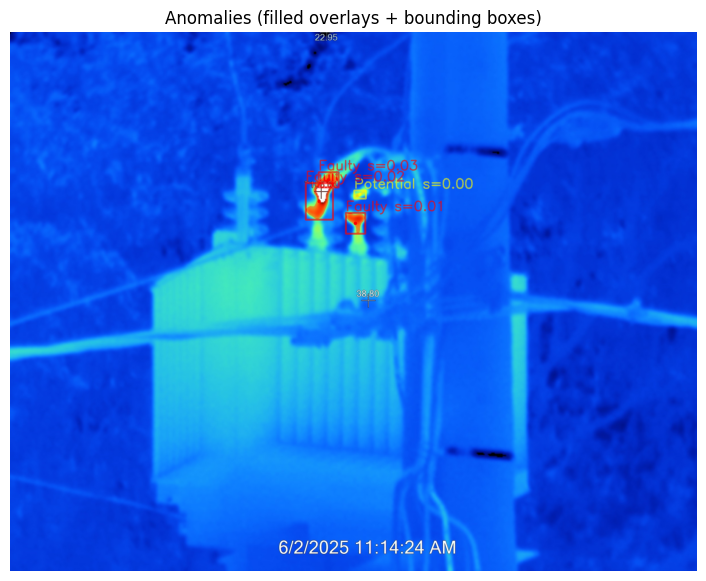

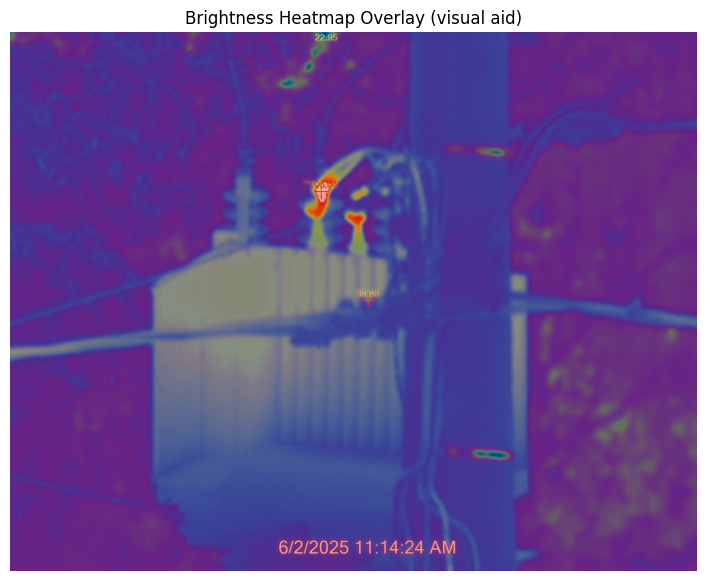

Anomaly metadata:
[1] bbox=(1196, 644, 69, 74)  centroid=(1230, 681)  area_px=2314  severity=0.0065  label=Faulty
[2] bbox=(1226, 564, 41, 29)  centroid=(1246, 578)  area_px=384  severity=0.0015  label=Potential
[3] bbox=(1053, 538, 97, 130)  centroid=(1101, 603)  area_px=3896  severity=0.0233  label=Faulty
[4] bbox=(1099, 499, 71, 54)  centroid=(1134, 526)  area_px=1571  severity=0.0349  label=Faulty
Saved: T12_faulty_001_annotated.png
Saved: T12_faulty_001_heatmap.png


In [29]:
# === Phase 2 · Automatic Anomaly Marking (built on your method) ===
from google.colab import files
import cv2, numpy as np, matplotlib.pyplot as plt, os

print("Upload a FAULTY thermal image (jpg/png):")
up = files.upload()
assert len(up) > 0, "No file uploaded."
image_path = list(up.keys())[0]

def detect_anomalies(image_path,
                     min_area: int = 60,
                     ignore_right_ratio: float = 0.10,  # ignore temp scale on right (set 0.0 if not needed)
                     overlay_alpha: float = 0.35):
    """
    Returns:
      annotated_img  -> original + filled overlays + bounding boxes + labels
      heatmap_blend  -> original + brightness heatmap (for visualization)
      anomalies      -> list of dicts with bbox, centroid, area_px, severity, label
    """
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(image_path)
    H, W = img.shape[:2]
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    v   = hsv[:, :, 2]

    # --- Your masks (kept), slightly stricter S/V helps reduce rails ---
    mask_red    = cv2.inRange(hsv, (0,  60, 180), (20, 255, 255))   # Faulty (red/orange)
    mask_yellow = cv2.inRange(hsv, (20, 60, 180), (40, 255, 255))   # Potential (yellow)
    mask = cv2.bitwise_or(mask_red, mask_yellow)

    # Optional: ignore the rightmost strip (temperature color bar found on many thermal exports)
    if ignore_right_ratio > 0:
        cut = int(W * (1.0 - ignore_right_ratio))
        for m in (mask, mask_red, mask_yellow):
            m[:, cut:] = 0

    # --- Clean noise AND ensure the whole anomaly is captured ---
    k_open  = np.ones((3, 3), np.uint8)
    k_close = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k_open, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k_close, iterations=1)
    mask = cv2.dilate(mask, np.ones((3,3), np.uint8), iterations=1)  # expands to cover full blob

    # --- Find connected regions ---
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    overlay = img.copy()     # to paint filled color regions
    annotated = img.copy()   # final output (we'll blend overlay into this)
    anomalies = []

    # helper: severity via local contrast around bbox
    def severity_from_bbox(x, y, w, h, region_mask):
        roi_v   = v[y:y+h, x:x+w]
        roi_hot = region_mask[y:y+h, x:x+w]
        if cv2.countNonZero(roi_hot) == 0:
            return 0.0
        hot_mean = cv2.mean(roi_v, mask=roi_hot)[0]
        rim = cv2.dilate(roi_hot, np.ones((11,11), np.uint8), iterations=1)
        bg_mask = cv2.subtract(rim, roi_hot)
        bg_mask = np.where(bg_mask > 0, 255, 0).astype(np.uint8)
        bg_mean = cv2.mean(roi_v, mask=bg_mask)[0] if cv2.countNonZero(bg_mask) else float(np.mean(roi_v))
        contrast = max(0.0, (hot_mean - bg_mean) / 255.0)   # 0..1
        area_norm = min(1.0, (w*h) / (H*W*0.05))            # cap at 5% of image
        severity = float(min(1.0, 0.7*contrast + 0.3*area_norm))
        return severity

    for cnt in contours:
        area = int(cv2.contourArea(cnt))
        if area < min_area:
            continue

        x, y, w, h = cv2.boundingRect(cnt)
        # Slight bbox padding so the rectangle fully wraps the glow
        pad = 2
        x = max(0, x - pad); y = max(0, y - pad)
        w = min(W - x, w + 2*pad); h = min(H - y, h + 2*pad)

        # Decide label/color by red vs yellow pixels inside this bbox
        red_px = cv2.countNonZero(mask_red[y:y+h, x:x+w])
        yel_px = cv2.countNonZero(mask_yellow[y:y+h, x:x+w])
        if red_px > yel_px:
            label = "Faulty"
            color = (0, 0, 255)     # red
        else:
            label = "Potential"
            color = (0, 255, 255)   # yellow

        # Build a per-contour binary mask for severity + overlay fill
        region_mask = np.zeros((H, W), np.uint8)
        cv2.drawContours(region_mask, [cnt], -1, 255, -1)

        severity = severity_from_bbox(x, y, w, h, region_mask)
        cx, cy = x + w // 2, y + h // 2

        # --- Filled overlay (semi-transparent) ---
        cv2.drawContours(overlay, [cnt], -1, color, thickness=-1)

        # --- Bounding box + label + centroid ---
        th = max(2, int(min(H, W) * 0.003))
        font_scale = max(0.5, min(H, W) / 1200.0)
        cv2.rectangle(annotated, (x, y), (x + w, y + h), color, th)
        cv2.circle(annotated, (cx, cy), max(2, th + 1), color, -1)
        cv2.putText(annotated, f"{label} s={severity:.2f}",
                    (x, max(20, y - 8)), cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, max(2, th - 1))

        anomalies.append({
            "bbox": (int(x), int(y), int(w), int(h)),
            "centroid": (int(cx), int(cy)),
            "area_px": int(area),
            "severity": round(severity, 4),
            "label": label
        })

    # --- Blend overlay into the annotated image (transparent fill under the boxes) ---
    annotated = cv2.addWeighted(overlay, overlay_alpha, annotated, 1 - overlay_alpha, 0)

    # --- Heatmap view (bonus) ---
    # Normalize V channel, blur, colorize, and blend with original.
    v_norm = cv2.normalize(v, None, 0, 255, cv2.NORM_MINMAX)
    v_blur = cv2.GaussianBlur(v_norm, (0, 0), sigmaX=7, sigmaY=7)
    heat = cv2.applyColorMap(v_blur.astype(np.uint8), cv2.COLORMAP_JET)
    heatmap_blend = cv2.addWeighted(img, 0.6, heat, 0.4, 0)

    return annotated, heatmap_blend, anomalies


# === Run detection on uploaded image ===
annotated_img, heatmap_img, meta = detect_anomalies(image_path)

# Show: overlays+boxes
plt.figure(figsize=(12, 7))
plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Anomalies (filled overlays + bounding boxes)")
plt.show()

# Show: heatmap blend (optional visual)
plt.figure(figsize=(12, 7))
plt.imshow(cv2.cvtColor(heatmap_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Brightness Heatmap Overlay (visual aid)")
plt.show()

# Metadata printout
if len(meta) == 0:
    print("No anomalies found with current thresholds.")
else:
    print("Anomaly metadata:")
    for i, m in enumerate(meta, 1):
        print(f"[{i}] bbox={m['bbox']}  centroid={m['centroid']}  "
              f"area_px={m['area_px']}  severity={m['severity']}  label={m['label']}")

# Save images
stem, _ = os.path.splitext(image_path)
cv2.imwrite(f"{stem}_annotated.png", annotated_img)
cv2.imwrite(f"{stem}_heatmap.png", heatmap_img)
print("Saved:", f"{stem}_annotated.png")
print("Saved:", f"{stem}_heatmap.png")
